## Dataset load

In [1]:
from simpl_loader import load_simpl_module

simpl = load_simpl_module()

In [2]:
from network_builder import GraphBuilder, SimplicialComplexBuilder, HyperGraphBuilder

In [3]:
import matplotlib.pyplot as plt

In [4]:
from dataset_loader import DatasetLoader

sets, true_labels = DatasetLoader.load_dataset("contact-high-school")
# sets, true_labels = DatasetLoader.load_dataset("contact-primary-school")
# sets, true_labels = DatasetLoader.load_dataset("house-bills")
# sets, true_labels = DatasetLoader.load_dataset("senate-bills")

In [5]:
print(f"Number of sets: {len(sets)}")
print(f"Number of vertices: {len(true_labels)}")

Number of sets: 7818
Number of vertices: 327


In [6]:
# Simplify model of contact dataset on 3 classes -- 123, 459, 678
def compress_labels():
    for i in range(len(true_labels)):
        if true_labels[i] in [1, 2, 3]:
            true_labels[i] = 0
        elif true_labels[i] in [4, 5, 9]:
            true_labels[i] = 1
        elif true_labels[i] in [6, 7, 8]:
            true_labels[i] = 2
        else:
            assert False

    with open("./data/node-compact-labels-contact-high-school.txt", "w") as f:
        for i in range(len(true_labels)):
            f.write(f"{true_labels[i]+1}\n")


# compress_labels()

In [7]:
# labeled_hyper_edges = list(map(lambda row: list(map(lambda x: true_labels[x], row)), sets))

## Dataset info

In [8]:
E = len(sets)
V = len(true_labels)
K = len(set(true_labels))
print(f"Number of edges: {E}")
print(f"Number of vertices: {V}")
print(f"Number of classes: {K}")
num_eig = min(V, 2 * K + 10)

Number of edges: 7818
Number of vertices: 327
Number of classes: 9


In [9]:
RUN = 20  # number of attempts

## ML prep

In [10]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [11]:
np.random.seed(123)

In [12]:
def solve(X, y, random_state=42) -> float:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = LogisticRegression(
        max_iter=1000, multi_class="multinomial", solver="lbfgs", random_state=42
    )
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled).reshape(-1, 1)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


def mean_solve(X, y, n_iter=RUN, debug=True) -> float:
    results = []
    for it in range(n_iter):
        results.append(solve(X, y, 42 + it))
    mean_acc = np.mean(results)
    if debug:
        print(f"Mean accuracy: {mean_acc:.5f}")
    return mean_acc

In [13]:
y = np.array(true_labels)

In [14]:
def iterate_eigenvalues(eigenvectors):
    result = []
    for i in range(1, num_eig + 1):
        X = eigenvectors[:, :i]
        result.append(mean_solve(X, y))
    return result

In [15]:
random_scores = []
# Random scorer
for i in range(RUN):
    y_pred = np.random.choice(1, size=len(y))
    random_scores.append(accuracy_score(np.random.choice(K, size=len(y)), y))
print(f"Random score: {np.mean(random_scores)}")

Random score: 0.11116207951070337


## Graph

In [16]:
graph_builder = GraphBuilder()
graph = graph_builder.create_network(sets, True)

In [17]:
# clos0 = graph.ClosenessAll(0, 1, False)
# clos1 = graph.ClosenessAll(1, 2, False)

In [18]:
# for s, w in clos0:
#     graph.UpdateWeight(s, w)
# for s, w in clos1:
#     graph.UpdateWeight(s, w)

In [19]:
# for simplex in graph.GetAll():
#     if len(simplex) == 0:
#         continue
#     # w = 1 / max(len(simplex), 1)
#     w = graph.Closeness(simplex, len(simplex))
#     graph.UpdateWeight(simplex, w)

In [20]:
graph.FVector()

[(0, 327), (1, 5818)]

In [21]:
results_graph_unweighted_norm = []
results_graph_weighted_norm = []
results_graph_unweighted = []
results_graph_weighted = []

In [22]:
results_graph_unweighted = iterate_eigenvalues(
    np.array(graph.EigenValues(0, -1, 1, False, False, num_eig, "sm")[1])
)

Mean accuracy: 0.10758
Mean accuracy: 0.27273
Mean accuracy: 0.44899
Mean accuracy: 0.57222
Mean accuracy: 0.68485
Mean accuracy: 0.77475
Mean accuracy: 0.85000
Mean accuracy: 0.87980
Mean accuracy: 0.89646
Mean accuracy: 0.91465
Mean accuracy: 0.94646
Mean accuracy: 0.94596
Mean accuracy: 0.95253
Mean accuracy: 0.95000
Mean accuracy: 0.96263
Mean accuracy: 0.96364
Mean accuracy: 0.97626
Mean accuracy: 0.97727
Mean accuracy: 0.97929
Mean accuracy: 0.97677
Mean accuracy: 0.97677
Mean accuracy: 0.97525
Mean accuracy: 0.97424
Mean accuracy: 0.96970
Mean accuracy: 0.97020
Mean accuracy: 0.96970
Mean accuracy: 0.96616
Mean accuracy: 0.96566


In [23]:
results_graph_weighted = iterate_eigenvalues(
    np.array(graph.EigenValues(0, -1, 1, True, False, num_eig, "sm")[1])
)

Mean accuracy: 0.14949
Mean accuracy: 0.42980
Mean accuracy: 0.62576
Mean accuracy: 0.78485
Mean accuracy: 0.90051
Mean accuracy: 0.90707
Mean accuracy: 0.96010
Mean accuracy: 0.97778
Mean accuracy: 0.98838
Mean accuracy: 0.98939
Mean accuracy: 0.99091
Mean accuracy: 0.98939
Mean accuracy: 0.98889
Mean accuracy: 0.98788
Mean accuracy: 0.98636
Mean accuracy: 0.98737
Mean accuracy: 0.98788
Mean accuracy: 0.98737
Mean accuracy: 0.98788
Mean accuracy: 0.98737
Mean accuracy: 0.98788
Mean accuracy: 0.98939
Mean accuracy: 0.98939
Mean accuracy: 0.98788
Mean accuracy: 0.98838
Mean accuracy: 0.98788
Mean accuracy: 0.98838
Mean accuracy: 0.99040


In [24]:
results_graph_unweighted_norm = iterate_eigenvalues(
    np.array(graph.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1])
)

Mean accuracy: 0.13434
Mean accuracy: 0.42222
Mean accuracy: 0.66162
Mean accuracy: 0.75404
Mean accuracy: 0.90707
Mean accuracy: 0.96667
Mean accuracy: 0.98030
Mean accuracy: 0.98232
Mean accuracy: 1.00000
Mean accuracy: 0.99899
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99899
Mean accuracy: 0.99798
Mean accuracy: 0.99899
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99848
Mean accuracy: 0.99798
Mean accuracy: 0.99747
Mean accuracy: 0.99646
Mean accuracy: 0.99495
Mean accuracy: 0.99444
Mean accuracy: 0.99545
Mean accuracy: 0.99495
Mean accuracy: 0.99495
Mean accuracy: 0.99394


In [25]:
results_graph_weighted_norm = iterate_eigenvalues(
    np.array(graph.EigenValues(0, -1, 1, True, True, num_eig, "sm")[1])
)

Mean accuracy: 0.13636
Mean accuracy: 0.42576
Mean accuracy: 0.61414
Mean accuracy: 0.77020
Mean accuracy: 0.84040
Mean accuracy: 0.90202
Mean accuracy: 0.94697
Mean accuracy: 0.95354
Mean accuracy: 0.95606
Mean accuracy: 0.95556
Mean accuracy: 0.95758
Mean accuracy: 0.97273
Mean accuracy: 0.97020
Mean accuracy: 0.96970
Mean accuracy: 0.97626
Mean accuracy: 0.97576
Mean accuracy: 0.97222
Mean accuracy: 0.97222
Mean accuracy: 0.97424
Mean accuracy: 0.97576
Mean accuracy: 0.97576
Mean accuracy: 0.97424
Mean accuracy: 0.97424
Mean accuracy: 0.97525
Mean accuracy: 0.97576
Mean accuracy: 0.97475
Mean accuracy: 0.97424
Mean accuracy: 0.97222


In [26]:
# clos = np.array([val[1] for val in graph.ClosenessAll(0, 1, True)]).reshape(-1, 1)
# betw = np.array([val[1] for val in graph.BetweennessAll(0, 1, True)]).reshape(-1, 1)

In [27]:
# mean_solve(clos, y)
# mean_solve(betw, y)

### Feature evaluator

### Hypergraph 

In [28]:
hyper_graph_builder = HyperGraphBuilder()
hyper_graph = hyper_graph_builder.create_network(sets, True)

In [29]:
hyper_graph.FVector()

[(0, 327), (1, 7818)]

In [30]:
results_hyper_graph_unweighted = []
results_hyper_graph_weighted = []
results_hyper_graph_unweighted_norm = []
results_hyper_graph_weighted_norm = []

In [31]:
results_hyper_graph_unweighted = iterate_eigenvalues(
    np.array(hyper_graph.EigenValues(0, -1, 1, False, False, num_eig, "sm")[1])
)

Mean accuracy: 0.21465
Mean accuracy: 0.35303
Mean accuracy: 0.46313
Mean accuracy: 0.54798
Mean accuracy: 0.61061
Mean accuracy: 0.67222
Mean accuracy: 0.67727
Mean accuracy: 0.78535
Mean accuracy: 0.81364
Mean accuracy: 0.83333
Mean accuracy: 0.83384
Mean accuracy: 0.83939
Mean accuracy: 0.86667
Mean accuracy: 0.91263
Mean accuracy: 0.91970
Mean accuracy: 0.93384
Mean accuracy: 0.93889
Mean accuracy: 0.93889
Mean accuracy: 0.94394
Mean accuracy: 0.97273
Mean accuracy: 0.96768
Mean accuracy: 0.97020
Mean accuracy: 0.97475
Mean accuracy: 0.97273
Mean accuracy: 0.97020
Mean accuracy: 0.97374
Mean accuracy: 0.97727
Mean accuracy: 0.97929


In [32]:
results_hyper_graph_weighted = iterate_eigenvalues(
    np.array(hyper_graph.EigenValues(0, -1, 1, True, False, num_eig, "sm")[1])
)

Mean accuracy: 0.12525
Mean accuracy: 0.41061
Mean accuracy: 0.58535
Mean accuracy: 0.72828
Mean accuracy: 0.84848
Mean accuracy: 0.91616
Mean accuracy: 0.97323
Mean accuracy: 0.98434
Mean accuracy: 0.99091
Mean accuracy: 0.99141
Mean accuracy: 0.99091
Mean accuracy: 0.99141
Mean accuracy: 0.99141
Mean accuracy: 0.99040
Mean accuracy: 0.99040
Mean accuracy: 0.99091
Mean accuracy: 0.99444
Mean accuracy: 0.99444
Mean accuracy: 0.99444
Mean accuracy: 0.99495
Mean accuracy: 0.99646
Mean accuracy: 0.99596
Mean accuracy: 0.99495
Mean accuracy: 0.99545
Mean accuracy: 0.99495
Mean accuracy: 0.99596
Mean accuracy: 0.99343
Mean accuracy: 0.99394


In [33]:
results_hyper_graph_unweighted_norm = iterate_eigenvalues(
    np.array(hyper_graph.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1])
)

Mean accuracy: 0.11465
Mean accuracy: 0.41566
Mean accuracy: 0.61313
Mean accuracy: 0.81616
Mean accuracy: 0.84798
Mean accuracy: 0.92525
Mean accuracy: 0.97273
Mean accuracy: 0.98889
Mean accuracy: 0.99091
Mean accuracy: 0.99242
Mean accuracy: 0.99141
Mean accuracy: 0.99192
Mean accuracy: 0.99192
Mean accuracy: 0.99192
Mean accuracy: 0.99495
Mean accuracy: 0.99495
Mean accuracy: 0.99545
Mean accuracy: 0.99545
Mean accuracy: 0.99596
Mean accuracy: 0.99646
Mean accuracy: 0.99596
Mean accuracy: 0.99545
Mean accuracy: 0.99545
Mean accuracy: 0.99545
Mean accuracy: 0.99495
Mean accuracy: 0.99545
Mean accuracy: 0.99444
Mean accuracy: 0.99444


In [34]:
results_hyper_graph_weighted_norm = iterate_eigenvalues(
    np.array(hyper_graph.EigenValues(0, -1, 1, True, True, num_eig, "sm")[1])
)

Mean accuracy: 0.13232
Mean accuracy: 0.45758
Mean accuracy: 0.60556
Mean accuracy: 0.79192
Mean accuracy: 0.86768
Mean accuracy: 0.91717
Mean accuracy: 0.95354
Mean accuracy: 0.96515
Mean accuracy: 0.96414
Mean accuracy: 0.96667
Mean accuracy: 0.96616
Mean accuracy: 0.96616
Mean accuracy: 0.96212
Mean accuracy: 0.96616
Mean accuracy: 0.95960
Mean accuracy: 0.96364
Mean accuracy: 0.96566
Mean accuracy: 0.96919
Mean accuracy: 0.96919
Mean accuracy: 0.97071
Mean accuracy: 0.97323
Mean accuracy: 0.97424
Mean accuracy: 0.97475
Mean accuracy: 0.96869
Mean accuracy: 0.97020
Mean accuracy: 0.96970
Mean accuracy: 0.96869
Mean accuracy: 0.97071


## Hodge

In [35]:
eigenvectors = np.array(graph.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1])

In [36]:
eigenvectors.shape

(327, 28)

In [37]:
# eig_decomposition = np.zeros((eigenvectors.shape[0], 0))
# for i in range(eigenvectors.shape[1]):
#     c1, c2, c3 = graph.HodgeDecomposition(0, -1, 1, list(eigenvectors[:, i]))

#     c1 = np.array(c1).reshape(-1, 1)
#     c2 = np.array(c2).reshape(-1, 1)
#     c3 = np.array(c3).reshape(-1, 1)

#     to_add = []
#     for c in [c1, c2, c3]:
#         if np.isfinite(c).all() and not np.all(c == c[0]):
#             to_add.append(c)
#         else:
#             print("skip")

#     if len(to_add) > 0:
#         eig_decomposition = np.hstack((eig_decomposition, *to_add))
#     X = np.asarray(eig_decomposition)
#     mean_solve(X, y)

In [38]:
# eig_decomposition = np.asarray(eig_decomposition)

In [39]:
# result = []
# for i in range(3, 6 * K, +3):
#     X = eig_decomposition[:, :i]
#     result.append(mean_solve(X, y))

## Simplicial complex

In [40]:
simplicial_complex_builder = SimplicialComplexBuilder()
simpl_complex = simplicial_complex_builder.create_network(sets, True)

In [41]:
simpl_complex.FVector()

[(0, 327), (1, 5818), (2, 2370), (3, 238), (4, 7)]

In [42]:
results_simpl_complex_unweighted = []
results_simpl_complex_weighted = []
results_simpl_complex_unweighted_norm = []
results_simpl_complex_weighted_norm = []

In [43]:
results_simpl_complex_unweighted = iterate_eigenvalues(
    np.array(simpl_complex.EigenValues(0, -1, 1, False, False, num_eig, "sm")[1])
)

Mean accuracy: 0.10758
Mean accuracy: 0.27273
Mean accuracy: 0.44899
Mean accuracy: 0.57222
Mean accuracy: 0.68485
Mean accuracy: 0.77475
Mean accuracy: 0.85000
Mean accuracy: 0.87980
Mean accuracy: 0.89646
Mean accuracy: 0.91465
Mean accuracy: 0.94646
Mean accuracy: 0.94596
Mean accuracy: 0.95253
Mean accuracy: 0.95000
Mean accuracy: 0.96263
Mean accuracy: 0.96364
Mean accuracy: 0.97626
Mean accuracy: 0.97727
Mean accuracy: 0.97929
Mean accuracy: 0.97677
Mean accuracy: 0.97677
Mean accuracy: 0.97525
Mean accuracy: 0.97424
Mean accuracy: 0.96970
Mean accuracy: 0.97020
Mean accuracy: 0.96970
Mean accuracy: 0.96616
Mean accuracy: 0.96566


In [44]:
results_simpl_complex_weighted = iterate_eigenvalues(
    np.array(simpl_complex.EigenValues(0, -1, 1, True, False, num_eig, "sm")[1])
)

Mean accuracy: 0.12879
Mean accuracy: 0.41515
Mean accuracy: 0.63485
Mean accuracy: 0.78434
Mean accuracy: 0.82525
Mean accuracy: 0.92828
Mean accuracy: 0.96616
Mean accuracy: 0.98030
Mean accuracy: 0.98990
Mean accuracy: 0.98939
Mean accuracy: 0.98889
Mean accuracy: 0.98788
Mean accuracy: 0.98636
Mean accuracy: 0.98586
Mean accuracy: 0.98737
Mean accuracy: 0.98788
Mean accuracy: 0.98485
Mean accuracy: 0.98586
Mean accuracy: 0.98990
Mean accuracy: 0.98889
Mean accuracy: 0.98838
Mean accuracy: 0.98838
Mean accuracy: 0.98788
Mean accuracy: 0.98687
Mean accuracy: 0.98636
Mean accuracy: 0.98535
Mean accuracy: 0.98535
Mean accuracy: 0.97929


In [45]:
results_simpl_complex_unweighted_norm = iterate_eigenvalues(
    np.array(simpl_complex.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1])
)

Mean accuracy: 0.13434
Mean accuracy: 0.42222
Mean accuracy: 0.66162
Mean accuracy: 0.75404
Mean accuracy: 0.90707
Mean accuracy: 0.96667
Mean accuracy: 0.98030
Mean accuracy: 0.98232
Mean accuracy: 1.00000
Mean accuracy: 0.99899
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99899
Mean accuracy: 0.99798
Mean accuracy: 0.99899
Mean accuracy: 0.99949
Mean accuracy: 0.99949
Mean accuracy: 0.99848
Mean accuracy: 0.99798
Mean accuracy: 0.99747
Mean accuracy: 0.99646
Mean accuracy: 0.99495
Mean accuracy: 0.99444
Mean accuracy: 0.99545
Mean accuracy: 0.99495
Mean accuracy: 0.99495
Mean accuracy: 0.99394


In [46]:
results_simpl_complex_weighted_norm = iterate_eigenvalues(
    np.array(simpl_complex.EigenValues(0, -1, 1, True, True, num_eig, "sm")[1])
)

Mean accuracy: 0.13283
Mean accuracy: 0.41818
Mean accuracy: 0.61869
Mean accuracy: 0.77929
Mean accuracy: 0.84646
Mean accuracy: 0.90354
Mean accuracy: 0.92323
Mean accuracy: 0.95455
Mean accuracy: 0.95859
Mean accuracy: 0.95808
Mean accuracy: 0.96111
Mean accuracy: 0.97071
Mean accuracy: 0.97828
Mean accuracy: 0.97828
Mean accuracy: 0.97980
Mean accuracy: 0.97778
Mean accuracy: 0.97778
Mean accuracy: 0.97576
Mean accuracy: 0.97828
Mean accuracy: 0.97677
Mean accuracy: 0.97677
Mean accuracy: 0.97727
Mean accuracy: 0.97727
Mean accuracy: 0.97525
Mean accuracy: 0.97576
Mean accuracy: 0.97576
Mean accuracy: 0.97677
Mean accuracy: 0.97576


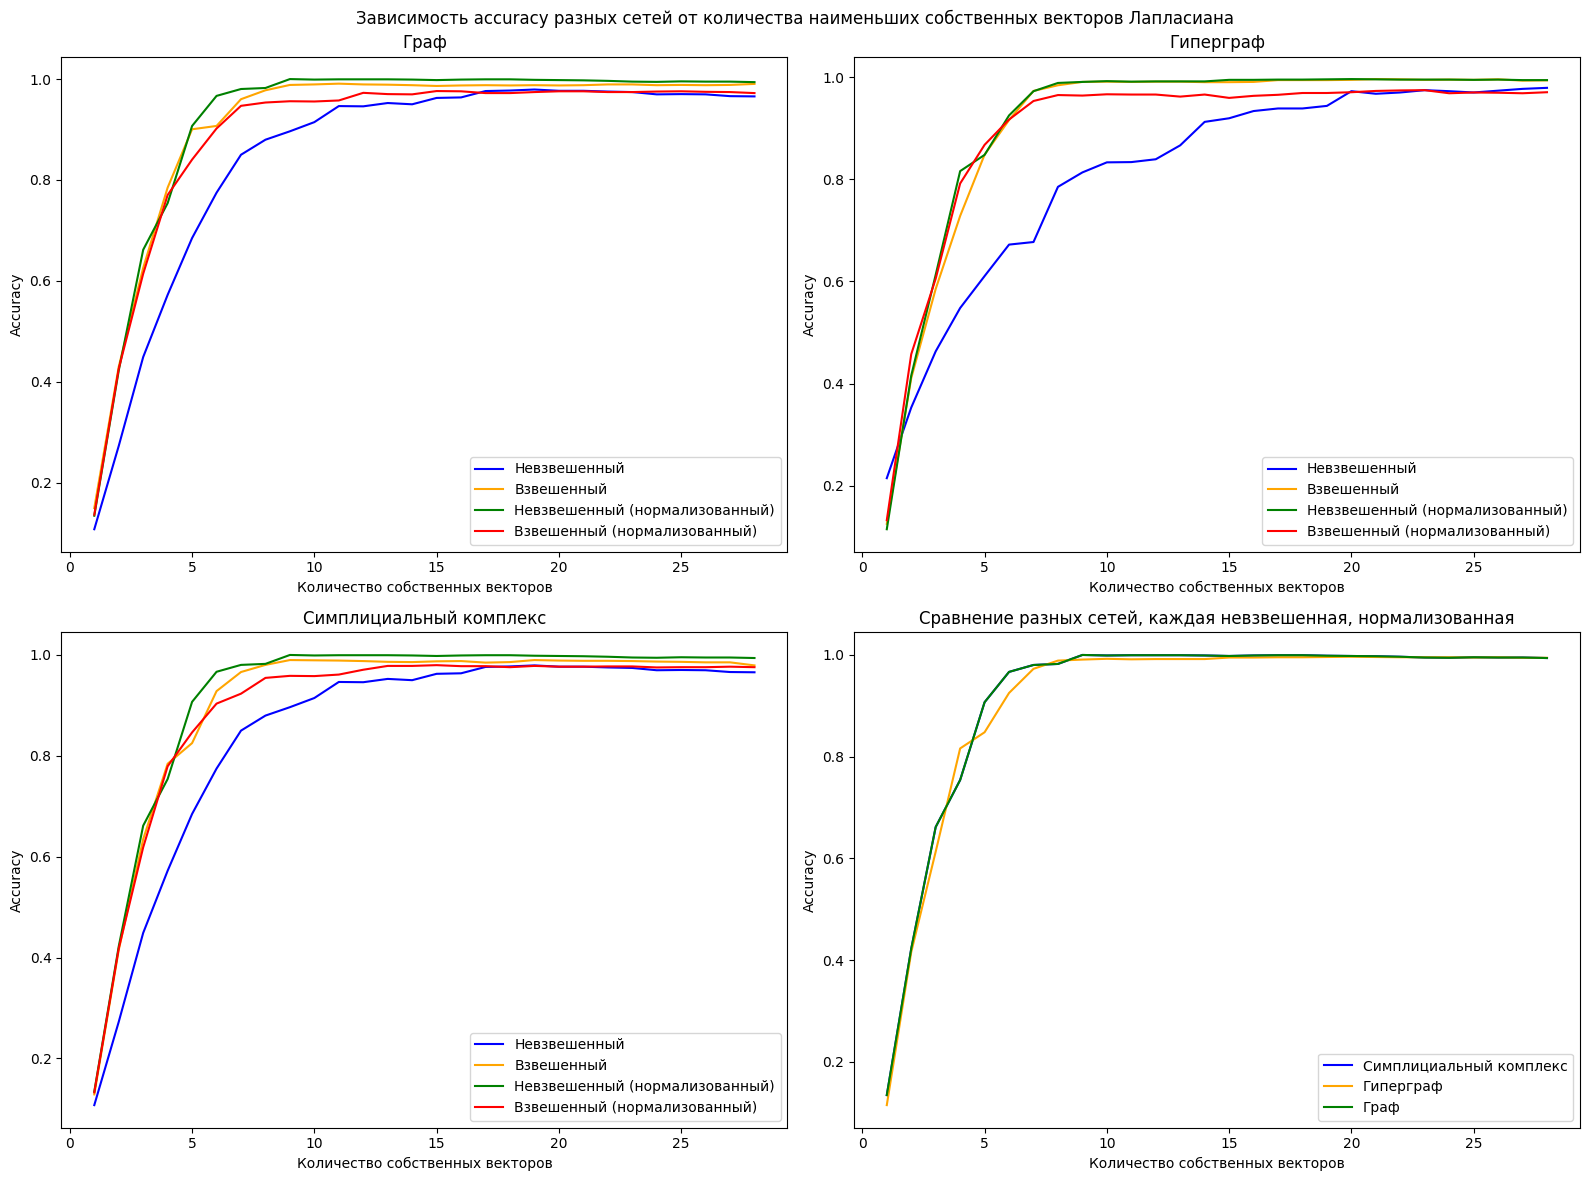

In [47]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

fig.suptitle(
    "Зависимость accuracy разных сетей от количества наименьших собственных векторов Лапласиана"
)
iterations = [i for i in range(1, num_eig + 1)]

# Graph
axs[0, 0].plot(iterations, results_graph_unweighted, label="Невзвешенный", color="blue")
axs[0, 0].plot(iterations, results_graph_weighted, label="Взвешенный", color="orange")
axs[0, 0].plot(
    iterations,
    results_graph_unweighted_norm,
    label="Невзвешенный (нормализованный)",
    color="green",
)
axs[0, 0].plot(
    iterations,
    results_graph_weighted_norm,
    label="Взвешенный (нормализованный)",
    color="red",
)
axs[0, 0].set_title("Граф")
axs[0, 0].set_xlabel("Количество собственных векторов")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

# Hypergraph
axs[0, 1].plot(
    iterations, results_hyper_graph_unweighted, label="Невзвешенный", color="blue"
)
axs[0, 1].plot(
    iterations, results_hyper_graph_weighted, label="Взвешенный", color="orange"
)
axs[0, 1].plot(
    iterations,
    results_hyper_graph_unweighted_norm,
    label="Невзвешенный (нормализованный)",
    color="green",
)
axs[0, 1].plot(
    iterations,
    results_hyper_graph_weighted_norm,
    label="Взвешенный (нормализованный)",
    color="red",
)
axs[0, 1].set_title("Гиперграф")
axs[0, 1].set_xlabel("Количество собственных векторов")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()

# Simplicial Complex
axs[1, 0].plot(
    iterations, results_simpl_complex_unweighted, label="Невзвешенный", color="blue"
)
axs[1, 0].plot(
    iterations, results_simpl_complex_weighted, label="Взвешенный", color="orange"
)
axs[1, 0].plot(
    iterations,
    results_simpl_complex_unweighted_norm,
    label="Невзвешенный (нормализованный)",
    color="green",
)
axs[1, 0].plot(
    iterations,
    results_simpl_complex_weighted_norm,
    label="Взвешенный (нормализованный)",
    color="red",
)
axs[1, 0].set_title("Симплициальный комплекс")
axs[1, 0].set_xlabel("Количество собственных векторов")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

# Comparison
axs[1, 1].plot(
    iterations,
    results_simpl_complex_unweighted_norm,
    label="Симплициальный комплекс",
    color="blue",
)
axs[1, 1].plot(
    iterations, results_hyper_graph_unweighted_norm, label="Гиперграф", color="orange"
)
axs[1, 1].plot(iterations, results_graph_unweighted_norm, label="Граф", color="green")
axs[1, 1].set_title("Сравнение разных сетей, каждая невзвешенная, нормализованная")
axs[1, 1].set_xlabel("Количество собственных векторов")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### Trying better

In [48]:
eigenvectors = np.array(
    simpl_complex.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1]
)

In [49]:
clos1 = np.array(
    [value for _, value in simpl_complex.ClosenessAll(0, 1, True)]
).reshape(-1, 1)
clos2 = np.array(
    [value for _, value in simpl_complex.ClosenessAll(0, 2, True)]
).reshape(-1, 1)
centr_eig1 = np.array(
    [value for _, value in simpl_complex.EigenCentrality(0, 1, True)]
).reshape(-1, 1)
centr_sub1 = np.array(
    [value for _, value in simpl_complex.SubgraphCentrality(0, 2, True)]
).reshape(-1, 1)
centr_eig2 = np.array(
    [value for _, value in simpl_complex.EigenCentrality(0, 2, True)]
).reshape(-1, 1)
centr_sub2 = np.array(
    [value for _, value in simpl_complex.SubgraphCentrality(0, 1, True)]
).reshape(-1, 1)
# betw1 = np.array(
#     [value for _, value in simpl_complex.BetweennessAll(0, 1, False)]
# ).reshape(-1, 1)
# betw2 = np.array(
#     [value for _, value in simpl_complex.BetweennessAll(0, 2, False)]
# ).reshape(-1, 1)

In [50]:
deg1 = np.array(simpl_complex.DegreeAll(0, 1, True)).reshape(-1, 1)
deg2 = np.array(simpl_complex.DegreeAll(0, 2, True)).reshape(-1, 1)
# deg3 = np.array(simpl_complex.DegreeAll(0, 3, True)).reshape(-1, 1)
# deg4 = np.array(simpl_complex.DegreeAll(0, 4, True)).reshape(-1, 1)

In [51]:
eigenvectors2 = np.array(
    simpl_complex.EigenValues(0, -1, 2, False, True, num_eig, "sm")[1]
)
# Only lapl(0, 2)
for i in range(1, num_eig + 1):
    X = eigenvectors2[:, :i]
    mean_solve(X, y)

Mean accuracy: 0.09646
Mean accuracy: 0.10152
Mean accuracy: 0.10152
Mean accuracy: 0.10000
Mean accuracy: 0.09646
Mean accuracy: 0.10202
Mean accuracy: 0.10758
Mean accuracy: 0.11010
Mean accuracy: 0.10758
Mean accuracy: 0.10505
Mean accuracy: 0.24697
Mean accuracy: 0.24949
Mean accuracy: 0.33030
Mean accuracy: 0.34747
Mean accuracy: 0.44091
Mean accuracy: 0.47677
Mean accuracy: 0.50505
Mean accuracy: 0.56313
Mean accuracy: 0.57626
Mean accuracy: 0.60354
Mean accuracy: 0.62323
Mean accuracy: 0.64798
Mean accuracy: 0.69444
Mean accuracy: 0.72172
Mean accuracy: 0.73081
Mean accuracy: 0.73485
Mean accuracy: 0.72980
Mean accuracy: 0.72929


In [52]:
# # Composition of Lapl1 and Lapl2
# for i in range(1, num_eig + 1):
#     for j in range(0, num_eig + 1):
#         X = eigenvectors[:, :i]
#         Y = eigenvectors2[:, :j]
#         X = np.hstack((X, Y))
#         mean_solve(X, y)

In [53]:
from itertools import product

# List of your feature names
features = [
    clos1,
    clos2,
    centr_eig1,
    centr_eig2,
    centr_sub1,
    # centr_sub2,
    # betw1,
    # betw2
]

feat_acc = []
for mask in product([0, 1], repeat=len(features)):
    selected = [f for f, m in zip(features, mask) if m]
    if len(selected) == 0:
        continue
    X = np.array(selected).reshape(len(selected[0]), len(selected))
    score = mean_solve(X, y)
    feat_acc.append((score, mask))
feat_acc.sort(key=lambda x: x[0], reverse=True)

feat_acc

Mean accuracy: 0.26465
Mean accuracy: 0.29646
Mean accuracy: 0.15253
Mean accuracy: 0.27172
Mean accuracy: 0.15253
Mean accuracy: 0.15152
Mean accuracy: 0.13788
Mean accuracy: 0.13081
Mean accuracy: 0.15253
Mean accuracy: 0.18737
Mean accuracy: 0.13788
Mean accuracy: 0.19848
Mean accuracy: 0.13788
Mean accuracy: 0.19141
Mean accuracy: 0.14343
Mean accuracy: 0.12525
Mean accuracy: 0.15253
Mean accuracy: 0.18838
Mean accuracy: 0.13788
Mean accuracy: 0.19798
Mean accuracy: 0.13788
Mean accuracy: 0.20455
Mean accuracy: 0.14343
Mean accuracy: 0.16212
Mean accuracy: 0.13788
Mean accuracy: 0.20859
Mean accuracy: 0.14343
Mean accuracy: 0.21162
Mean accuracy: 0.14343
Mean accuracy: 0.19848
Mean accuracy: 0.14040


[(0.2964646464646465, (0, 0, 0, 1, 0)),
 (0.2717171717171717, (0, 0, 1, 0, 0)),
 (0.2646464646464647, (0, 0, 0, 0, 1)),
 (0.2116161616161616, (1, 1, 1, 0, 0)),
 (0.2085858585858586, (1, 1, 0, 1, 0)),
 (0.2045454545454545, (1, 0, 1, 1, 0)),
 (0.1984848484848485, (0, 1, 1, 0, 0)),
 (0.1984848484848485, (1, 1, 1, 1, 0)),
 (0.19797979797979798, (1, 0, 1, 0, 0)),
 (0.19141414141414143, (0, 1, 1, 1, 0)),
 (0.18838383838383838, (1, 0, 0, 1, 0)),
 (0.18737373737373736, (0, 1, 0, 1, 0)),
 (0.1621212121212121, (1, 1, 0, 0, 0)),
 (0.1525252525252525, (0, 0, 0, 1, 1)),
 (0.1525252525252525, (0, 0, 1, 0, 1)),
 (0.1525252525252525, (0, 1, 0, 0, 1)),
 (0.1525252525252525, (1, 0, 0, 0, 1)),
 (0.15151515151515152, (0, 0, 1, 1, 0)),
 (0.14343434343434344, (0, 1, 1, 1, 1)),
 (0.14343434343434344, (1, 0, 1, 1, 1)),
 (0.14343434343434344, (1, 1, 0, 1, 1)),
 (0.14343434343434344, (1, 1, 1, 0, 1)),
 (0.1404040404040404, (1, 1, 1, 1, 1)),
 (0.13787878787878788, (0, 0, 1, 1, 1)),
 (0.13787878787878788, (0, 1, 

In [54]:
for x in [
    clos1,
    clos2,
    # betw1,
    # betw2,
    centr_eig1,
    centr_eig2,
    centr_sub1,
    centr_sub2,
]:
    for it in range(0, 2):
        X = x
        if it == 1:
            X = np.log1p(X)
        mean_solve(X, y)

Mean accuracy: 0.12525
Mean accuracy: 0.12677
Mean accuracy: 0.13081
Mean accuracy: 0.12929
Mean accuracy: 0.27172
Mean accuracy: 0.27172
Mean accuracy: 0.29646
Mean accuracy: 0.29596
Mean accuracy: 0.26465
Mean accuracy: 0.21010
Mean accuracy: 0.23838
Mean accuracy: 0.25909


In [55]:
mean_solve(np.hstack((clos1, clos2, centr_eig1, centr_eig2, centr_sub1, centr_sub2)), y)

Mean accuracy: 0.48333


0.4833333333333334

In [56]:
for i in range(1, num_eig + 1):
    X = eigenvectors[:, :i]
    old = mean_solve(X, y, debug=False)
    print(f"Old: {old}")

    X = np.hstack((X, clos1, clos2, centr_eig1, centr_eig2, centr_sub1, centr_sub2))
    best_score = mean_solve(X, y, debug=False)
    print(f"New: {best_score}")
    print(f"profit: {((best_score - old))*100:.2f}")
    # print(f"Old: {old} vs new: {new}")

Old: 0.13434343434343435
New: 0.49848484848484853
profit: 36.41
Old: 0.4222222222222222
New: 0.5823232323232324
profit: 16.01
Old: 0.6616161616161615
New: 0.7227272727272728
profit: 6.11
Old: 0.7540404040404041
New: 0.7893939393939393
profit: 3.54
Old: 0.9070707070707072
New: 0.8833333333333332
profit: -2.37
Old: 0.9666666666666666
New: 0.964141414141414
profit: -0.25
Old: 0.9803030303030302
New: 0.9712121212121211
profit: -0.91
Old: 0.9823232323232322
New: 0.9712121212121211
profit: -1.11
Old: 1.0
New: 0.9929292929292929
profit: -0.71
Old: 0.998989898989899
New: 0.9929292929292929
profit: -0.61
Old: 0.9994949494949494
New: 0.9929292929292929
profit: -0.66
Old: 0.9994949494949494
New: 0.9939393939393939
profit: -0.56
Old: 0.9994949494949494
New: 0.9944444444444445
profit: -0.51
Old: 0.998989898989899
New: 0.9934343434343434
profit: -0.56
Old: 0.997979797979798
New: 0.994949494949495
profit: -0.30
Old: 0.998989898989899
New: 0.9954545454545454
profit: -0.35
Old: 0.9994949494949494
New: 

## Hodge simpl

In [57]:
# eigenvectors = np.array(
#     simpl_complex.EigenValues(1, 0, 2, False, True, num_eig, "sm")[1]
# )

In [58]:
# edges = simpl_complex.GetSimplicesWithDimension(1)
# assert len(edges) == len(eigenvectors[:, 0])

In [59]:
# eigenvectors.shape

In [60]:
# # edge_high = []
# # edge_decompose_high = []

# edge_prime = []
# edge_decompose_prime = []

In [61]:
# for i in range(1, 1 + eigenvectors.shape[1]):
#     X = np.zeros((len(y), i))
#     for col in range(i):
#         for row, edge in enumerate(edges):
#             for v in edge:
#                 X[v][col] += eigenvectors[row][col]
#     # edge_high.append(mean_solve(X, y))
#     edge_prime.append(mean_solve(X, y))
#     # edge_house.append(mean_solve(X, y))
#     # edge_senate.append(mean_solve(X, y))

In [62]:
# eig_decomposition = np.zeros((eigenvectors.shape[0], 0))
# for i in range(eigenvectors.shape[1]):
#     c1, c2, c3 = simpl_complex.HodgeDecomposition(1, 0, 2, list(eigenvectors[:, i]))

#     c1 = np.array(c1).reshape(-1, 1)
#     c2 = np.array(c2).reshape(-1, 1)
#     c3 = np.array(c3).reshape(-1, 1)

#     to_add = []
#     for c in [c1, c2, c3]:
#         if np.isfinite(c).all() and not np.all(c == c[0]):
#             to_add.append(c)
#         else:
#             print("skip")

#     # to_add = [eigenvectors[:, i].reshape(-1, 1)]
#     if len(to_add) > 0:
#         eig_decomposition = np.hstack((eig_decomposition, *to_add))

#     X = np.zeros((len(y), eig_decomposition.shape[1]))
#     for col in range(eig_decomposition.shape[1]):
#         for row, edge in enumerate(edges):
#             for v in edge:
#                 X[v][col] += eig_decomposition[row][col]
#     # edge_decompose_high.append(mean_solve(X, y))
#     edge_decompose_prime.append(mean_solve(X, y))

In [63]:
# x1 = [i for i in range(1, len(edge_high) + 1)]
# x2 = [i for i in range(1, len(edge_prime) + 1)]


# # Create subplots: 1 row, 2 columns
# fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# fig.suptitle("Зависимость accuracy от количества собственных векторов в L1 лапласиане")

# # First plot
# axs[0].plot(x1, edge_high, label="Без разложения Ходжа", color="blue")
# axs[0].plot(x1, edge_decompose_high, label="C разложениeм Ходжа", color="red")
# axs[0].set_title("Старшая школа")
# axs[0].set_xlabel("Количество собственных векторов")
# axs[0].set_ylabel("Accuracy")
# axs[0].legend()

# # Second plot
# axs[1].plot(x2, edge_prime, label="Без разложения Ходжа", color="blue")
# axs[1].plot(x2, edge_decompose_prime, label="C разложениeм Ходжа", color="red")
# axs[1].set_title("Младшая школа")
# axs[1].set_xlabel("Количество собственных векторов")
# axs[1].set_ylabel("Accuracy")
# axs[1].legend()

# # Show both plots
# plt.tight_layout()
# plt.show()

## Testing

<!-- eigenvectors = np.array(graph.EigenValues(0, -1, 1, False, True, num_eig, "sm")[1])
eigenvectors.shape
eig_decomposition = np.zeros((eigenvectors.shape[0], 0))
for i in range(eigenvectors.shape[1]):
    c1, c2, c3 = graph.HodgeDecomposition(0, -1, 1, list(eigenvectors[:, i]))

    c1 = np.array(c1).reshape(-1, 1)
    c2 = np.array(c2).reshape(-1, 1)
    c3 = np.array(c3).reshape(-1, 1)

    to_add = []
    for c in [c1, c2, c3]:
        if np.isfinite(c).all() and not np.all(c == c[0]):
            to_add.append(c)
        else:
            print("skip")

    if len(to_add) > 0:
        eig_decomposition = np.hstack((eig_decomposition, *to_add))
    X = np.asarray(eig_decomposition)
    mean_solve(X, y) -->